https://github.com/makcedward/nlpaug#installation

In [ ]:
access_token = ""

In [2]:
idCuda = 3
idTorch = 0

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{str(idCuda)}"

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, default_data_collator, EarlyStoppingCallback, IntervalStrategy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Import all needed metrics
#from torch.utils.data import DataLoader, Dataset

In [5]:
torch.cuda.device_count()

1

In [6]:
torch.cuda.empty_cache()
torch.cuda.set_device(idTorch)

if torch.cuda.is_available():
    GPU = torch.cuda.get_device_name(idTorch)
    print(f"PyTorch available GPU: {GPU}")
else:
    print("GPU not available")

PyTorch available GPU: Quadro RTX 5000


In [7]:
device = torch.device(f"cuda:{idTorch}" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [8]:
topicos = False
fiveOrTree = False
classes = 3
classCol = 'sentiment'
if fiveOrTree:
    classes = 5
    classCol = 'scoreSA'

In [9]:
test_size = 0.2
locationOriginalDataset = '/home/patrick.araujo/topicModeling/out/export_outS_SpotifyAutoRU.csv'
print(f'Usando para o cojunto de teste {100-test_size*100}% e validação {test_size*100}% de:  "{locationOriginalDataset}"')
dataset = pd.read_csv(locationOriginalDataset)

Usando para o cojunto de teste 80.0% e validação 20.0% de:  "/home/patrick.araujo/topicModeling/out/export_outS_SpotifyAutoRU.csv"


In [10]:
dataset

,level_0,index,Time_submitted,content,score,Total_thumbsup,Reply,sentiment,lengthContent,Language,scoreSA,reviewId,topics
0,14924,15041,2022-05-31 09:39:51,The most inconvenient way to stream music or p...,1,0,NaN,0,377,en,0,13373,"['app', 'music', 'songs', 'spotify', 'song', '..."
1,55431,55686,2022-01-27 09:09:10,Free was fine before now there are too many ad...,1,11,NaN,0,93,en,0,9446,"['app', 'music', 'songs', 'spotify', 'song', '..."
2,56988,57245,2022-01-21 14:15:58,"just a three, i like the music and everything ...",3,0,NaN,1,208,en,2,15873,"['app', 'music', 'songs', 'spotify', 'song', '..."
3,29753,29962,2022-04-20 06:57:21,Could Be Alot Smoother If There Wasn't Glitchi...,4,0,NaN,2,56,en,3,9474,"['app', 'music', 'songs', 'spotify', 'song', '..."
4,31649,31867,2022-04-16 16:01:04,The problem with the downloaded songs not bein...,2,84,NaN,0,362,en,1,10101,"['app', 'music', 'songs', 'spotify', 'song', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20242,34704,34930,2022-04-13 00:34:47,I don't know why but it will play every possib...,1,1,NaN,0,273,en,0,2712,"['app', 'music', 'songs', 'spotify', 'song', '..."
20243,21602,21755,2022-05-10 18:25:56,Have used Spotify off and on for a few years. ...,5,0,NaN,2,145,en,4,8000,"['app', 'music', 'songs', 'spotify', 'song', '..."
20244,32942,33163,2022-04-14 19:02:45,Constant problems with this app usually crashe...,3,0,NaN,1,91,en,2,9698,"['app', 'music', 'songs', 'spotify', 'song', '..."
20245,4365,4394,2022-06-28 23:18:49,Thise are a very usefull app and it get u all ...,5,0,NaN,2,111,en,4,7242,"['app', 'music', 'songs', 'spotify', 'song', '..."


In [11]:
dataset.shape

(20247, 13)

In [12]:
score_counts_balanced = dataset['scoreSA'].value_counts().sort_index()
print(score_counts_balanced)

scoreSA
0    4834
1    1915
2    6749
3    1835
4    4914
Name: count, dtype: int64


In [13]:
sentiments_counts_balanced = dataset['sentiment'].value_counts().sort_index()
print(sentiments_counts_balanced)

sentiment
0    6749
1    6749
2    6749
Name: count, dtype: int64


In [14]:
generated_RO = dataset[dataset['index'].isna()]
df_original = dataset[~dataset['index'].isna()]

score_dfO_counts_balanced = df_original[classCol].value_counts().sort_index()
highest_count = score_dfO_counts_balanced.max()
highest_value = score_dfO_counts_balanced[score_dfO_counts_balanced == highest_count].index[0]

In [15]:
train_data_AllC = None
val_data_AllC = None

df_filtered_scMAX = df_original[df_original[classCol] == highest_value].reset_index(drop=True)
train_dataMAX, val_dataMAX = train_test_split(df_filtered_scMAX, test_size=test_size, random_state=42)

all_dfs_Train = []
all_dfs_Val = []

all_dfs_Train.append(train_dataMAX)
all_dfs_Val.append(val_dataMAX)

for score_value, count in score_dfO_counts_balanced.items():
    if (highest_value != score_value):
        df_filtered_scTemp = df_original[df_original[classCol] == score_value].reset_index(drop=True)
        train_dataTemp, val_dataTemp = train_test_split(df_filtered_scTemp, test_size=len(val_dataMAX), train_size=None, random_state=42)
        remainingGenRO = generated_RO[generated_RO[classCol] == score_value].reset_index(drop=True)
        merged_df = pd.concat([remainingGenRO, train_dataTemp])
        merged_df = merged_df.reset_index(drop=True)
        merged_df = merged_df.sample(frac=1)
        val_dataTemp = val_dataTemp.sample(frac=1)
        all_dfs_Train.append(merged_df)
        all_dfs_Val.append(val_dataTemp)
combined_df_Train = pd.concat(all_dfs_Train, ignore_index=True)
combined_df_Train = combined_df_Train.sample(frac=1)
train_data_AllC = combined_df_Train.reset_index(drop=True)
combined_df_Val = pd.concat(all_dfs_Val, ignore_index=True)
combined_df_Val = combined_df_Val.sample(frac=1)
val_data_AllC = combined_df_Val.reset_index(drop=True)

In [16]:
train_data_AllC

,level_0,index,Time_submitted,content,score,Total_thumbsup,Reply,sentiment,lengthContent,Language,scoreSA,reviewId,topics
0,18432,18566,2022-05-20 15:56:51,This app is good for hearing BTS songs 😂,4,0,NaN,2,40,en,3,13772,"['app', 'music', 'songs', 'spotify', 'song', '..."
1,37446,37674,2022-04-05 14:16:11,"Spotify is 🔥🔥🔥🔥 💯💯💯 if you can't find it here,...",5,0,NaN,2,96,en,4,14601,"['app', 'music', 'songs', 'spotify', 'song', '..."
2,9180,9254,2022-06-16 21:56:43,Spotify should be able to download on Mac but ...,3,0,NaN,1,53,en,2,19446,"['app', 'music', 'songs', 'spotify', 'song', '..."
3,45162,45403,2022-03-06 11:15:16,Like ...real good man....the app is so legit.....,5,0,NaN,2,168,en,4,18380,"['app', 'music', 'songs', 'spotify', 'song', '..."
4,26079,26265,2022-04-27 16:32:05,App is the shhhit...alot of repetitive music o...,3,0,NaN,1,141,en,2,6342,"['app', 'music', 'songs', 'spotify', 'song', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,1679,1685,2022-07-05 15:45:05,Annoying. Stop shuffling my music!,1,0,NaN,0,34,en,0,14766,"['app', 'music', 'songs', 'spotify', 'song', '..."
16193,13317,13422,2022-06-05 10:12:18,Still the best music streaming platform. Optio...,5,0,NaN,2,103,en,4,11547,"['app', 'music', 'songs', 'spotify', 'song', '..."
16194,13997,14108,2022-06-03 10:46:43,"It started out well, Not until the music stopp...",3,0,NaN,1,171,en,2,6210,"['app', 'music', 'songs', 'spotify', 'song', '..."
16195,56276,56531,2022-01-24 07:51:39,I love Spotify so much...it is the best app I ...,5,0,NaN,2,115,en,4,379,"['app', 'music', 'songs', 'spotify', 'song', '..."


In [17]:
val_data_AllC

,level_0,index,Time_submitted,content,score,Total_thumbsup,Reply,sentiment,lengthContent,Language,scoreSA,reviewId,topics
0,20937,21087,2022-05-12 23:13:16,I don't like when songs keep disappearing spec...,4,0,NaN,2,186,en,3,9569,"['app', 'music', 'songs', 'spotify', 'song', '..."
1,34322,34547,2022-04-13 12:13:03,"Normally, I love this app, but lately it's bee...",3,0,NaN,1,215,en,2,4713,"['app', 'music', 'songs', 'spotify', 'song', '..."
2,8145,8211,2022-06-19 13:54:51,"Hmm, so much ads, and if you are thinking you ...",1,0,NaN,0,101,en,0,6316,"['app', 'music', 'songs', 'spotify', 'song', '..."
3,9657,9732,2022-06-15 17:10:40,It used to be ok because you would get ads lik...,5,0,NaN,2,255,en,4,11587,"['app', 'music', 'songs', 'spotify', 'song', '..."
4,55225,55480,2022-01-27 21:16:33,It is appalling you have to pay just to fast f...,1,0,NaN,0,55,en,0,3616,"['app', 'music', 'songs', 'spotify', 'song', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045,29385,29593,2022-04-20 18:13:46,Excellent app never let's you down I love it h...,5,0,NaN,2,63,en,4,14809,"['app', 'music', 'songs', 'spotify', 'song', '..."
4046,48252,48496,2022-02-20 18:43:14,I have been using paid version of spotify for ...,5,0,NaN,2,86,en,4,17459,"['app', 'music', 'songs', 'spotify', 'song', '..."
4047,43339,43579,2022-03-09 18:29:28,"nice. it woulda been 5 stars, but there's more...",3,2,NaN,1,256,en,2,18386,"['app', 'music', 'songs', 'spotify', 'song', '..."
4048,3243,3263,2022-07-01 16:05:50,Love group listen and shared playlists,5,0,NaN,2,38,en,4,1868,"['app', 'music', 'songs', 'spotify', 'song', '..."


In [18]:
print(val_data_AllC[val_data_AllC['index'].isna()])

Empty DataFrame
Columns: [level_0, index, Time_submitted, content, score, Total_thumbsup, Reply, sentiment, lengthContent, Language, scoreSA, reviewId, topics]
Index: []


In [19]:
train_data = None
val_data = None

if topicos:
    train_data = train_data_AllC[['content', 'topics', classCol]]
    val_data = val_data_AllC[['content', 'topics', classCol]]
else:
    train_data = train_data_AllC[['content', classCol]]
    val_data = val_data_AllC[['content', classCol]]

In [20]:
# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, token=access_token)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Move model to GPU
model = model.to(device)

Essa parte garante que os dados serão balanceados tanto para treino como para testagem

In [22]:
print("Training Data")
print(train_data[classCol].value_counts().sort_index())
print("\nValidation Data")
print(val_data[classCol].value_counts().sort_index())

Training Data
sentiment
0    5399
1    5399
2    5399
Name: count, dtype: int64

Validation Data
sentiment
0    1350
1    1350
2    1350
Name: count, dtype: int64


In [23]:
train_data

,content,sentiment
0,This app is good for hearing BTS songs 😂,2
1,"Spotify is 🔥🔥🔥🔥 💯💯💯 if you can't find it here,...",2
2,Spotify should be able to download on Mac but ...,1
3,Like ...real good man....the app is so legit.....,2
4,App is the shhhit...alot of repetitive music o...,1
...,...,...
16192,Annoying. Stop shuffling my music!,0
16193,Still the best music streaming platform. Optio...,2
16194,"It started out well, Not until the music stopp...",1
16195,I love Spotify so much...it is the best app I ...,2


In [24]:
val_data

,content,sentiment
0,I don't like when songs keep disappearing spec...,2
1,"Normally, I love this app, but lately it's bee...",1
2,"Hmm, so much ads, and if you are thinking you ...",0
3,It used to be ok because you would get ads lik...,2
4,It is appalling you have to pay just to fast f...,0
...,...,...
4045,Excellent app never let's you down I love it h...,2
4046,I have been using paid version of spotify for ...,2
4047,"nice. it woulda been 5 stars, but there's more...",1
4048,Love group listen and shared playlists,2


In [25]:
max_length = 512

In [26]:
def tokenizerFunctionWithTopics(string, topics):
    # Tokenize using tokenizer function
    string_list = eval(topics)
    tokens = tokenizer.encode_plus(string, topics, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokens

def tokenizerFunction(string):
    # Tokenize without topics
    tokens = tokenizer(string, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokens

# Assuming train_data and val_data are defined somewhere in your code
train_encodings = train_data['content'].apply(tokenizerFunction)
if topicos:
    train_encodings = train_data.apply(lambda x: tokenizerFunctionWithTopics(x['content'], x['topics']), axis=1)
val_encodings = val_data['content'].apply(tokenizerFunction)

In [27]:
train_encodings

0        [input_ids, token_type_ids, attention_mask]
1        [input_ids, token_type_ids, attention_mask]
2        [input_ids, token_type_ids, attention_mask]
3        [input_ids, token_type_ids, attention_mask]
4        [input_ids, token_type_ids, attention_mask]
                            ...                     
16192    [input_ids, token_type_ids, attention_mask]
16193    [input_ids, token_type_ids, attention_mask]
16194    [input_ids, token_type_ids, attention_mask]
16195    [input_ids, token_type_ids, attention_mask]
16196    [input_ids, token_type_ids, attention_mask]
Name: content, Length: 16197, dtype: object

In [28]:
val_encodings

0       [input_ids, token_type_ids, attention_mask]
1       [input_ids, token_type_ids, attention_mask]
2       [input_ids, token_type_ids, attention_mask]
3       [input_ids, token_type_ids, attention_mask]
4       [input_ids, token_type_ids, attention_mask]
                           ...                     
4045    [input_ids, token_type_ids, attention_mask]
4046    [input_ids, token_type_ids, attention_mask]
4047    [input_ids, token_type_ids, attention_mask]
4048    [input_ids, token_type_ids, attention_mask]
4049    [input_ids, token_type_ids, attention_mask]
Name: content, Length: 4050, dtype: object

In [29]:
def creatingDataframe(encodings):
  indices = encodings.index.to_numpy()

  df = pd.DataFrame(columns=['input_ids', 'attention_mask'])
  
  # Assuming 'content' is a Series or List containing tuples/lists
  for element in encodings:
    input_ids = element['input_ids'][0].numpy()              # Replace with correct index based on your data structure
    attention_mask = element['attention_mask'][0].numpy()    # Replace with correct index
    df.loc[len(df.index)] = [input_ids, attention_mask]
  df_index = pd.DataFrame(indices, columns=['index'])
  df['index'] = df_index['index']
  return df

# Batch Size

In [30]:
# Define batch size and create data loaders
batch_size = 16  # Adjust as needed

In [31]:
# Create datasets
# Convert labels to tensors
train_dataset = creatingDataframe(train_encodings)
train_labels = train_data[classCol].reset_index(name='label')
train_dataset = pd.merge(train_dataset, train_labels, on='index')

val_dataset = creatingDataframe(val_encodings)
val_labels = val_data[classCol].reset_index(name='label')
val_dataset = pd.merge(val_dataset, val_labels, on='index')

In [32]:
train_dataset = train_dataset.drop('index', axis=1)
val_dataset = val_dataset.drop('index', axis=1)

In [33]:
train_dataset

,input_ids,attention_mask,label
0,"[101, 2023, 10439, 2003, 2204, 2005, 4994, 184...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",2
1,"[101, 3962, 8757, 2003, 100, 100, 2065, 2017, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
2,"[101, 3962, 8757, 2323, 2022, 2583, 2000, 8816...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",1
3,"[101, 2066, 1012, 1012, 1012, 2613, 2204, 2158...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
4,"[101, 10439, 2003, 1996, 14021, 23644, 4183, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
...,...,...,...
16192,"[101, 15703, 1012, 2644, 24770, 2026, 2189, 99...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",0
16193,"[101, 2145, 1996, 2190, 2189, 11058, 4132, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
16194,"[101, 2009, 2318, 2041, 2092, 1010, 2025, 2127...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
16195,"[101, 1045, 2293, 3962, 8757, 2061, 2172, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [34]:
val_dataset

,input_ids,attention_mask,label
0,"[101, 1045, 2123, 1005, 1056, 2066, 2043, 2774...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
1,"[101, 5373, 1010, 1045, 2293, 2023, 10439, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,"[101, 17012, 1010, 2061, 2172, 14997, 1010, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
3,"[101, 2009, 2109, 2000, 2022, 7929, 2138, 2017...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
4,"[101, 2009, 2003, 10439, 8095, 2075, 2017, 203...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...
4045,"[101, 6581, 10439, 2196, 2292, 1005, 1055, 201...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
4046,"[101, 1045, 2031, 2042, 2478, 3825, 2544, 1997...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
4047,"[101, 3835, 1012, 2009, 2052, 2050, 2042, 1019...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4048,"[101, 2293, 2177, 4952, 1998, 4207, 2377, 2710...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",2


In [35]:
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)

In [36]:
path = ''

In [37]:
# Define training arguments with early stopping
training_args = TrainingArguments(
    # Positional arguments:
    output_dir = path + "./bert-base-uncased_sentiment_model",
    logging_dir = path + "./logs_bbu",

    # Keyword arguments:
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    #eval_steps=250,                         # Adjust as needed
    #save_total_limit=2,                     # Adjust as needed. Only last 2 models are saved. Older ones are deleted.
    num_train_epochs=5,                     # Adjust as needed
    #save_steps=500,                         # Adjust as needed
    metric_for_best_model="eval_loss",      # Use validation loss for early stopping
    learning_rate= 7e-05,
    warmup_steps=500,
    weight_decay=0.001,
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [38]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, mean_absolute_error

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Convert logits to predicted labels
    predicted_labels = np.argmax(logits, axis=1)

    metrics = {}
    # Calculate accuracy
    accuracy = accuracy_score(labels, predicted_labels)
    # balanced_accuracy = balanced_accuracy_score(labels, predicted_labels)
    metrics['accuracy'] = accuracy
    # metrics['balanced_accuracy'] = balanced_accuracy

    # Calculate accuracy for each class
    class_accuracy = {}
    for i in range(len(np.unique(labels))):
        class_indices = np.where(labels == i)[0]
        class_accuracy[f'class_{i}'] = accuracy_score(labels[class_indices], predicted_labels[class_indices])
    
    # Calculate precision, recall, F1 score, and support for each class
    precision, recall, f1, support = precision_recall_fscore_support(labels, predicted_labels)    
    
    # Create a dictionary to store metrics for each class
    class_metrics = {}
    # Include class-wise accuracy in the metrics
    i = 0
    for class_name, acc in class_accuracy.items():
        class_metrics[f'class_{i}'] = {
            'accuracy': acc,
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': support[i]
        }
        i = i+1

    precision_ALL = precision_score(labels, predicted_labels, average='macro')
    recall_ALL = recall_score(labels, predicted_labels, average='macro')
    f1_ALL = f1_score(labels, predicted_labels, average='macro')
    mae_ALL = mean_absolute_error(labels, predicted_labels)
    
    metrics['precision'] = precision_ALL
    metrics['recall'] = recall_ALL
    metrics['f1'] = f1_ALL
    metrics['mae'] = mae_ALL
    # Print and return the metrics
    for class_name, c_metrics in class_metrics.items():
        metrics[f'{class_name}_accuracy'] = c_metrics["accuracy"]
        metrics[f'{class_name}_precision'] = c_metrics["precision"]
        metrics[f'{class_name}_recall'] = c_metrics["recall"]
        metrics[f'{class_name}_f1'] = c_metrics["f1"]
        metrics[f'{class_name}_support'] = c_metrics["support"]

    return metrics

In [39]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [40]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mae,Class 0 Accuracy,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 0 Support,Class 1 Accuracy,Class 1 Precision,Class 1 Recall,Class 1 F1,Class 1 Support,Class 2 Accuracy,Class 2 Precision,Class 2 Recall,Class 2 F1,Class 2 Support
1,0.736700,0.677489,0.697778,0.716292,0.697778,0.703479,0.323704,0.674815,0.685478,0.674815,0.680105,1350,0.668148,0.566939,0.668148,0.613397,1350,0.750370,0.896460,0.750370,0.816935,1350
2,0.642000,0.698506,0.699506,0.702730,0.699506,0.698349,0.327160,0.775556,0.654375,0.775556,0.709831,1350,0.535556,0.600000,0.535556,0.565949,1350,0.787407,0.853815,0.787407,0.819268,1350
3,0.464800,0.823055,0.703457,0.702640,0.703457,0.696598,0.329630,0.802222,0.646181,0.802222,0.715796,1350,0.482222,0.638862,0.482222,0.549599,1350,0.825926,0.822878,0.825926,0.824399,1350
4,0.260600,1.034800,0.690370,0.695025,0.690370,0.692300,0.334321,0.670370,0.692956,0.670370,0.681476,1350,0.608148,0.567773,0.608148,0.587268,1350,0.792593,0.824345,0.792593,0.808157,1350
5,0.142400,1.555456,0.690123,0.697517,0.690123,0.692880,0.334815,0.705926,0.672548,0.705926,0.688833,1350,0.596296,0.569307,0.596296,0.582489,1350,0.768148,0.850697,0.768148,0.807318,1350


Checkpoint destination directory ./bert-base-uncased_sentiment_model/checkpoint-1013 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./bert-base-uncased_sentiment_model/checkpoint-2026 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./bert-base-uncased_sentiment_model/checkpoint-3039 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./bert-base-uncased_sentiment_model/checkpoint-4052 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./bert-base-uncased_sentiment_model/checkpoint-5065 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=5065, training_loss=0.4695615662991824, metrics={'train_runtime': 3844.3167, 'train_samples_per_second': 21.066, 'train_steps_per_second': 1.318, 'total_flos': 2.130862276744704e+16, 'train_loss': 0.4695615662991824, 'epoch': 5.0})

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the trainer to predict labels on the validation dataset
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extract the true labels from the validation dataset
true_labels = val_dataset['label']

# Generate the confusion matrix
unique_labels = np.sort(dataset[classCol].unique())

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)

print("Confusion Matrix:")
print(conf_matrix)
# Mapping from number to string

mapping = {0: 'Negative (0)', 1: 'Neutral (1)', 2: 'Positive (2)'}
if fiveOrTree:
    mapping = {0: 'Very Negative (1)', 1: 'Negative (2)', 2: 'Neutral (3)', 3: 'Positive (4)', 4: 'Very Positive (5)'}

# Applying mapping
classes = [mapping[value] for value in unique_labels]

Confusion Matrix:
[[ 911  418   21]
 [ 352  902   96]
 [  66  271 1013]]


In [42]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    plt.savefig(f'{filename}.png',  bbox_inches='tight')
    plt.savefig(f'{filename}.svg',  bbox_inches='tight')

/tmp/ipykernel_614713/703857389.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)


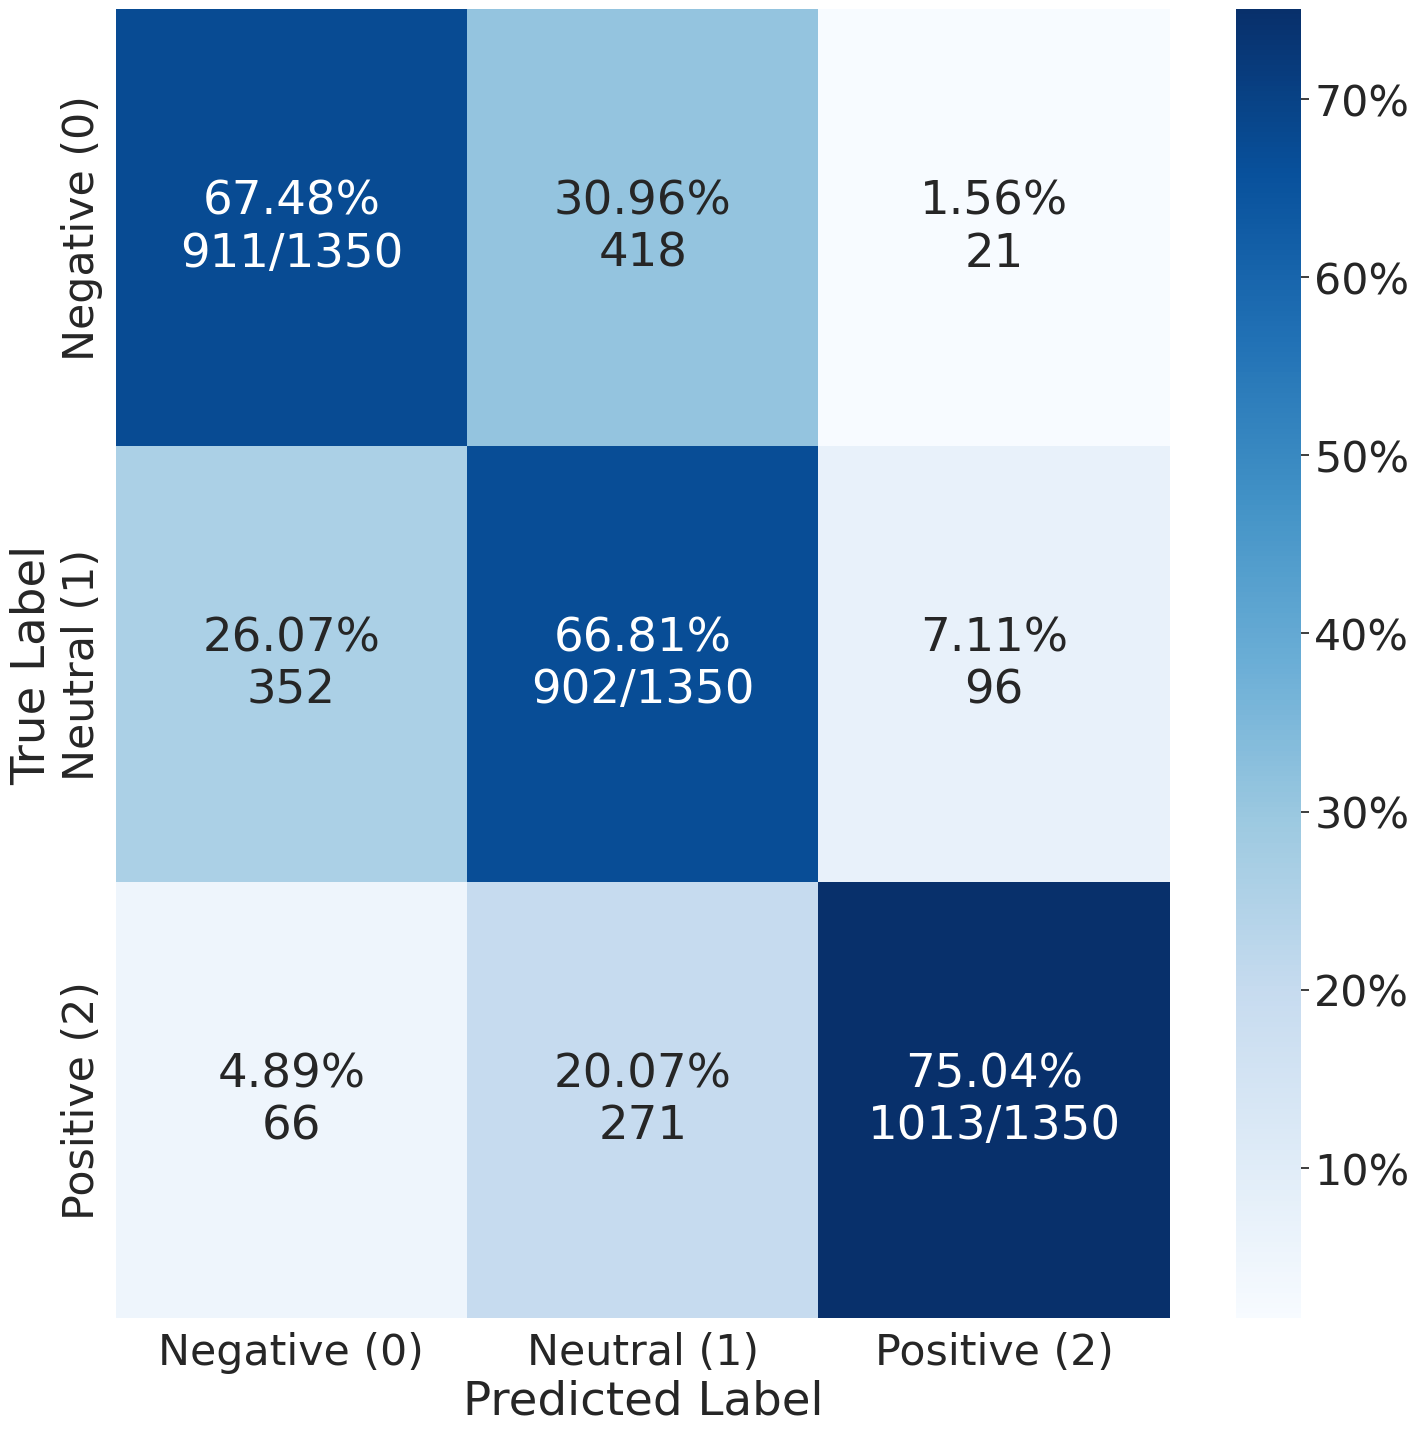

In [43]:
cm_analysis(true_labels, predicted_labels, 'confusion_matrix_BERTs', unique_labels, classes)

In [44]:
# Evaluate the model
results = trainer.evaluate()

In [45]:
results

{'eval_loss': 0.6774885654449463,
 'eval_accuracy': 0.6977777777777778,
 'eval_precision': 0.7162923373019181,
 'eval_recall': 0.6977777777777779,
 'eval_f1': 0.7034789347632907,
 'eval_mae': 0.3237037037037037,
 'eval_class_0_accuracy': 0.6748148148148149,
 'eval_class_0_precision': 0.6854778028592927,
 'eval_class_0_recall': 0.6748148148148149,
 'eval_class_0_f1': 0.6801045166106756,
 'eval_class_0_support': 1350,
 'eval_class_1_accuracy': 0.6681481481481482,
 'eval_class_1_precision': 0.5669390320553112,
 'eval_class_1_recall': 0.6681481481481482,
 'eval_class_1_f1': 0.6133968038082285,
 'eval_class_1_support': 1350,
 'eval_class_2_accuracy': 0.7503703703703704,
 'eval_class_2_precision': 0.8964601769911504,
 'eval_class_2_recall': 0.7503703703703704,
 'eval_class_2_f1': 0.8169354838709677,
 'eval_class_2_support': 1350,
 'eval_runtime': 59.9281,
 'eval_samples_per_second': 67.581,
 'eval_steps_per_second': 4.238,
 'epoch': 5.0}

In [46]:
output_file_path = './bert-base-uncased_sentiment_model'
destination = path+output_file_path

# Save the model
model.save_pretrained(destination)